## Objective

- Build DQN and PPO Deep RL algorithms
- Learn the difference between Q Learning and Policy Gradient techniques

## Imports

In [2]:
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models, io
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

import glob
import base64
import cv2

from IPython import display

from simulation import Simulator, coordinate

/fsg/hps22/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simulator Setup

In [3]:
def reset_sim():
    
    # Units are pixels for resolution, degrees for fov, degrees for angle, and pixels for height.
    cameraSettings = {
        "resolution": (1920, 1080),
        "fov": {"diagonal": random.uniform(74, 80)}, # realsense diagonal fov is 77 degrees IIRC
        "angle": {"roll": random.uniform(-5, 5), "pitch": random.uniform(10, 20), "yaw": random.uniform(-5, 5)}, # don't go too crazy with these, my code should be good up to like... 45 degrees probably? But the math gets unstable
        "height": random.uniform(58, 74) # 8 pixels/inch - represents how high up the camera is relative to the road
    }

    mapParameters = {
    "loops": 1,
    "size": (6, 6),
    "expansions": 5,
    "complications": 4
    }

    # Can also pass car parameters for max/min speed, etc
    carParameters = {
        "wheelbase": random.uniform(5.5, 7.5), # inches, influences how quickly the steering will turn the car.  Larger = slower
        "maxSteering": 30.0, # degrees, extreme (+ and -) values of steering
        "steeringOffset": random.uniform(-.5, .5), # degrees, since the car is rarely perfectly aligned
        "minVelocity": 0.0, # pixels/second, slower than this doesn't move at all.
        "maxVelocity": 480.0, # pixels/second, 8 pixels/inch, so if the car can move 5 fps that gives us 480 pixels/s top speed
    }

    sim = Simulator(cameraSettings=cameraSettings)
    
    # startLocation = (random.randint(0, 5), random.randint(0, 5), 0, random.randint(0, 2))
    # random seed for consistent maps
    # can also pass a start location if you know the code: (y tile index, x tile index, position index, direction index)
    # - position index is from 0-(number of connections the tile has - 1), so a straight is 0 or 1, a t is 0, 1, or 2.
    # - direction index is 0 or 1 for normal or reversed.
    sim.start(mapSeed='real', mapParameters=mapParameters, carParameters=carParameters, startPoint=(0,4,0,0))
    where, facing = sim.RealSense.parent.ackermann.pose()
    initial_img = sim.RealSense.camera.getImage(where, facing)
    return sim, initial_img

From here, the API for using the simulation is as follows. Steps the entire simulation, returns image, reward from sim.getReward() and a done bool (and we can change what 'done' means. Currently its if reward is negative):

```python
frame, reward, done = sim.step(steer, speed, display=False) 
```

In order to reset the simulation, you just need to reconstruct the sim object and start it, using the reset_sim() function above.

# DQN

## Part 1

Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.

### TODO

- Implement get action method with e-greedy policy
- Implement sample batch method
- Implement DQN learning algorithm



In [4]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
  """
  
  if random.uniform(0., 1.) < epsilon:
    action = random.randint(0,6) #randint 0-6 corresponding to [-30,-20,-10,0,10,20,30] degrees
  else:
    with torch.no_grad():
      state_tensor = torch.Tensor(state).float().cuda()
      # output = network(state_tensor).cpu()
      # doutput = output.detach().cpu()
      action = int(np.argmax(network(state_tensor).cpu()))
      del state_tensor
  return action, epsilon*epsilon_decay


def prepare_batch(memory, trajectory_length):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
  """
  frame = []
  action = []
  next_frame = []
  reward = []
  done = []

  resize_transform = transforms.Resize(size=(72,128))
  
  # rand_mem = random.sample(memory, batch_size)
  # frame = np.zeros((trajectory_length, *img_shape))
  # action = np.zeros(trajectory_length)
  # next_frame = np.zeros(frame.shape)
  # reward = np.zeros(action.shape)
  # m_done
  
  for m_frame, m_action, m_next_frame, m_reward, m_done in memory:
    frame.append(cv2.resize(m_frame, (128,72)))
    action.append(m_action)
    next_frame.append(cv2.resize(m_next_frame, (128,72)))
    reward.append(m_reward)
    done.append(m_done)

  frame = np.array(frame)
  action = np.array(action)
  next_frame = np.array(next_frame)
  reward = np.array(reward)
  done = np.array(done)

  return torch.FloatTensor(frame).cuda(), torch.FloatTensor(action).cuda(),torch.FloatTensor(next_frame).cuda(), \
          torch.FloatTensor(reward).cuda(), torch.FloatTensor(done).cuda()
  
def learn_dqn(trajectory, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
  """
  optim.zero_grad()
  total_loss = torch.tensor([0.0], requires_grad=True).cuda()
  episode_len = len(trajectory[0])


  for time_step in range(episode_len):
    state = trajectory[0][time_step] 
    action =trajectory[1][time_step] 
    next_state = trajectory[2][time_step] 
    reward = trajectory[3][time_step] 
    done = trajectory[4][time_step] 

    # Sequentially loop through the episode trajectory
    action = torch.unsqueeze(action.unsqueeze(0),dim=0).long()

    Q = torch.gather(q_network(state), 1, action)
    Q_hat = torch.max(target_network(next_state), dim=1)[0]
    b = (reward + gamma*Q_hat*(1 - done))

    Q = torch.squeeze(Q)
    b = torch.squeeze(b)
    
    total_loss = total_loss.item() + F.mse_loss(Q, b)

  total_loss.backward()
  optim.step()

  if global_step % target_update == 0:
    target_network.load_state_dict(q_network.state_dict())


### Modules

In [5]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, feature_size = 100, action_size = 7):
    super().__init__()
    
    hidden_size = 10
    
    self.resnet50 = models.resnet18(models.ResNet18_Weights.DEFAULT)
    self.resnet50.fc = nn.Linear(in_features=self.resnet50.fc.in_features, out_features=feature_size)

    self.lstm = nn.LSTM(feature_size, hidden_size, num_layers=1, batch_first=True)
    self.label = nn.Linear(hidden_size, action_size)

    self.prev_hidden_state = torch.zeros(self.lstm.num_layers, hidden_size).cuda()
    self.prev_cell_state =  torch.zeros(self.lstm.num_layers, hidden_size).cuda()
    
  def forward(self, img):
    """Estimate q-values given image

      Args:
          img batch (4d tensor): size (batch_size, channel, height, width)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    img = transforms.functional.convert_image_dtype(img).permute([2,0,1])
    features = self.resnet50(img.unsqueeze(0))
    output, (final_hidden_state, final_cell_state) = self.lstm(features, (self.prev_hidden_state, self.prev_cell_state))

    self.prev_hidden_state = final_hidden_state.detach()
    self.prev_cell_state = final_cell_state.detach()

    # print(output.shape)
    # print(final_hidden_state.shape)
    # print(final_cell_state.shape)

    values = self.label(output)
    return values #size: (batch_size, action_size)

### Main

In [6]:
def dqn_main():
  gc.collect()
  torch.cuda.empty_cache()

  # Hyper parameters
  lr = 1e-3
  episodes = 100
  start_training = 1000
  gamma = 0.99
  batch_size = 32
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2
  save_frequency = 10  
  MAX_EPISODE_LENGTH = 200

  # Init networks
  q_network = QNetwork().cuda()
  target_network = QNetwork().cuda()
  target_network.load_state_dict(q_network.state_dict()) #copy q_network into target_network

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Init replay buffer
  trajectory = []

  # Begin main loop
  results_dqn = []
  loop = tqdm(total=episodes, position=0, leave=False)
  action_space = [-30,-20,-10,0,10,20,30]

  
  for global_step, episode in enumerate(range(episodes)):

    # Reset environment
    sim, frame = reset_sim()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < MAX_EPISODE_LENGTH:  # End after 200 steps 
      # Select e-greedy action
      action_idx, epsilon = get_action_dqn(q_network, frame, epsilon, epsilon_decay)

      # Take step
      next_frame, reward, done = sim.step(steer=action_space[action_idx], speed=1.5, display=False)

      # Store step in replay buffer
      trajectory.append((frame, action_idx, next_frame, reward, done))

      cum_reward += reward
      frame = next_frame  # Set current frame

      # cv2.imshow("car", next_frame)
      # print(f"Reward: {reward}, Action:{action_space[action_idx]}")

    # Train the network after episode ended
    # Sample batch
    batch = prepare_batch(trajectory, batch_size)
    # Train
    learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
    del batch
      

    if global_step % save_frequency == 0:
      torch.save(q_network, f'./rl_models/model{global_step}.pt')

    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    f = r-a  # free inside reserved

    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    # gc.collect()
    # torch.cuda.empty_cache()
    loop.set_description('Episodes: {} Reward: {} Allocated Memory: {} Reserved Memory {}'.format(episode, cum_reward, a / 1e9, r / 1e9))
  
  return results_dqn

In [7]:
results_dqn = dqn_main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


In [216]:
print(results_dqn)

[58.0]


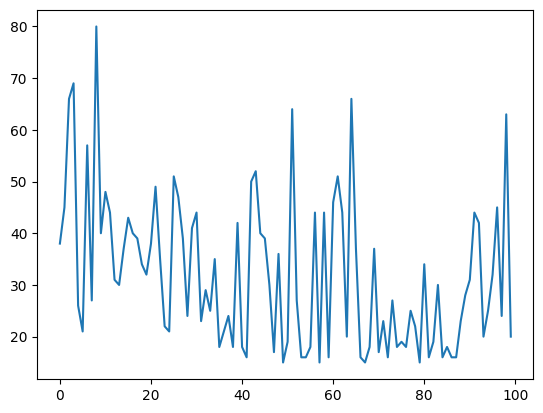

In [8]:
plt.plot(results_dqn)
plt.show()